# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
#!pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

ModuleNotFoundError: No module named 'seaborn'

## Fetch the data and load it in pandas

In [4]:
data = pd.read_csv("data/train.csv.bz2")
data2 = pd.read_csv("data/test.csv.bz2")

In [5]:
data2.head(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-05-21,LAS,ORD,12.000000,11.008268,9.860938
1,2012-12-20,SFO,DEN,10.600000,10.982615,9.954634
2,2012-11-01,LGA,DTW,11.950000,10.334322,9.207977
3,2012-01-03,DEN,LAS,11.476190,10.075862,9.352107
4,2012-11-19,LAX,ATL,13.444444,11.033573,10.363892


In [6]:
# Train
print(min(data['DateOfDeparture']))
print(max(data['DateOfDeparture']))

2011-09-01
2013-03-05


In [7]:
# Test
print(min(data2['DateOfDeparture']))
print(max(data2['DateOfDeparture']))

2011-09-01
2013-03-04


In [8]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [9]:
# Train
print(data.count())

DateOfDeparture     8902
Departure           8902
Arrival             8902
WeeksToDeparture    8902
log_PAX             8902
std_wtd             8902
dtype: int64


In [10]:
# Test
print(data2.count())

DateOfDeparture     2226
Departure           2226
Arrival             2226
WeeksToDeparture    2226
log_PAX             2226
std_wtd             2226
dtype: int64


In [11]:
data['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

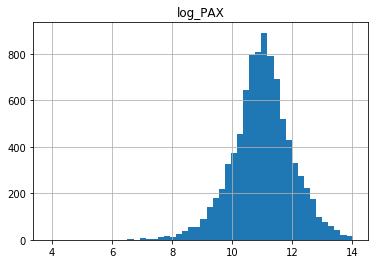

In [12]:
data.hist(column='log_PAX', bins=50);

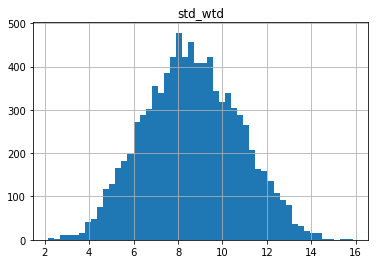

In [13]:
data.hist('std_wtd', bins=50);

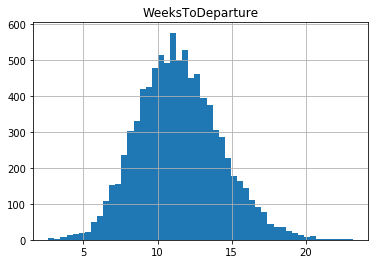

In [14]:
data.hist('WeeksToDeparture', bins=50);
#data.WeeksToDeparture.plot(kind = 'hist',bins = 50,figsize = (15,15))

In [15]:
data.describe()

,WeeksToDeparture,log_PAX,std_wtd
count,8902.000000,8902.000000,8902.000000
mean,11.446469,10.999048,8.617773
std,2.787140,0.993945,2.139604
min,2.625000,3.878108,2.160247
25%,9.523810,10.427055,7.089538
50%,11.300000,11.013357,8.571116
75%,13.240000,11.592888,10.140521
max,23.163265,14.007791,15.862216


In [16]:
data.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAX             float64
std_wtd             float64
dtype: object

In [17]:
data.shape

(8902, 6)

In [18]:
print(data['log_PAX'].mean())
print(data['log_PAX'].std())

10.9990476721
0.993945241175


In [19]:
holidays = pd.read_csv("data/us-federal-holidays-2011-2020.csv")

In [29]:
# On cherche les vols entre ces dates ci-dessous
print(min(data['DateOfDeparture']))
print(max(data['DateOfDeparture']))

2011-09-01
2013-03-05


In [22]:
# Conversion objet 'date' en datetime format
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [24]:
#on filtre sur les dates de vols en entree
holidays = holidays[(holidays['Date'] >= min(data['DateOfDeparture'])) & (holidays['Date'] <= max(data['DateOfDeparture']))]

In [31]:
holidays

,Date,Holiday
5,2011-09-05,Labor Day
6,2011-10-10,Columbus Day
7,2011-11-11,Veterans Day
8,2011-11-24,Thanksgiving Day
9,2011-12-26,Christmas Day
10,2012-01-02,New Year's Day
11,2012-01-16,"Birthday of Martin Luther King, Jr."
12,2012-02-20,Washington's Birthday
13,2012-05-28,Memorial Day
14,2012-07-04,Independence Day


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [62]:
data_encoded = data

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
data_encoded = data_encoded.drop('Departure', axis=1)
data_encoded = data_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))

In [63]:
data_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,10.427055,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,12.201552,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,10.508746,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,10.174042,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,2,3,6,5,15739,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,9.202674,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,26,5,47,15304,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [64]:
#data_encoded['Holidays'] = 0

### Croisement avec les jours feries

In [66]:
h = holidays.rename(columns={'Date': 'DateOfDeparture'})
dd = pd.merge(data_encoded, h, on='DateOfDeparture', how='left')

In [67]:
(dd['Holiday'].fillna(0) != 0).astype(int)

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      1
25      0
26      0
27      0
28      0
29      0
       ..
8872    0
8873    0
8874    0
8875    0
8876    0
8877    0
8878    0
8879    0
8880    0
8881    0
8882    0
8883    0
8884    0
8885    0
8886    0
8887    0
8888    0
8889    0
8890    0
8891    0
8892    0
8893    0
8894    0
8895    0
8896    0
8897    0
8898    0
8899    0
8900    0
8901    0
Name: Holiday, Length: 8902, dtype: int64

In [68]:
dd.Holiday.unique()

array([nan, 'Veterans Day', 'Christmas Day',
       'Birthday of Martin Luther King, Jr.', 'Thanksgiving Day',
       "New Year's Day", "Washington's Birthday", 'Columbus Day',
       'Independence Day', 'Labor Day', 'Memorial Day'], dtype=object)

In [69]:
dd['Holiday'] = (dd['Holiday'].fillna(0) != 0).astype(int)

In [70]:
dd

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52,Holiday
0,2012-06-19,12.875000,12.331296,9.812647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-09-10,14.285714,10.775182,9.466734,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,9,10,0,37,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-10-05,10.863636,11.083177,9.035883,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2012,10,5,4,40,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-10-09,11.480000,11.169268,7.990202,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2011,10,9,6,40,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2012-02-21,11.450000,11.269364,9.517159,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2012,2,21,1,8,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2013-01-22,10.363636,12.073649,8.232025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2013,1,22,1,4,15727,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2011-10-20,15.266667,11.173936,9.808277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2011,10,20,3,42,15267,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2012-01-28,8.588235,9.599952,6.165010,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,1,28,5,4,15367,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2012-05-27,10.238095,9.175645,6.609877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,27,6,21,15487,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [71]:
data_final = dd

In [73]:
data_final

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52,Holiday
0,2012-06-19,12.875000,12.331296,9.812647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-09-10,14.285714,10.775182,9.466734,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,9,10,0,37,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-10-05,10.863636,11.083177,9.035883,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2012,10,5,4,40,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-10-09,11.480000,11.169268,7.990202,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2011,10,9,6,40,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2012-02-21,11.450000,11.269364,9.517159,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2012,2,21,1,8,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2013-01-22,10.363636,12.073649,8.232025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2013,1,22,1,4,15727,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2011-10-20,15.266667,11.173936,9.808277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2011,10,20,3,42,15267,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2012-01-28,8.588235,9.599952,6.165010,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,1,28,5,4,15367,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2012-05-27,10.238095,9.175645,6.609877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,27,6,21,15487,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Croisement avec la meteo

In [76]:
df = pd.read_csv("data/weather.csv")

In [77]:
df1 = df.copy()
df2 = df.copy()

In [78]:
df1.rename(columns={'AirPort':'Departure','MaxTemperatureC':'DepMaxTemperatureC','MeanTemperatureC':'DepMeanTemperatureC','MinTemperatureC':'DepMinTemperatureC','DewPointC':'DepDewPointC','MeanDewPointC':'DepMeanDewPointC','MinDewpointC':'DepMinDewpointC','MaxHumidity':'DepMaxHumidity','MeanHumidity':'DepMeanHumidity','MinHumidity':'DepMinHumidity','MaxSeaLevelPressurehPa':'DepMaxSeaLevelPressurehPa','MeanSeaLevelPressurehPa':'DepMeanSeaLevelPressurehPa','MinSeaLevelPressurehPa':'DepMinSeaLevelPressurehPa','MaxVisibilityKm':'DepMaxVisibilityKm','MeanVisibilityKm':'DepMeanVisibilityKm','MinVisibilitykM':'DepMinVisibilitykM','MaxWindSpeedKmH':'DepMaxWindSpeedKmH','MeanWindSpeedKmH':'DepMeanWindSpeedKmH','MaxGustSpeedKmH':'DepMaxGustSpeedKmH','Precipitationmm':'DepPrecipitationmm','CloudCover':'DepCloudCover','Events':'DepEvents','WindDirDegrees':'DepWindDirDegrees'}, inplace=True)
df2.rename(columns={'AirPort':'Arrival','MaxTemperatureC':'ArrMaxTemperatureC','MeanTemperatureC':'ArrMeanTemperatureC','MinTemperatureC':'ArrMinTemperatureC','DewPointC':'ArrDewPointC','MeanDewPointC':'ArrMeanDewPointC','MinDewpointC':'ArrMinDewpointC','MaxHumidity':'ArrMaxHumidity','MeanHumidity':'ArrMeanHumidity','MinHumidity':'ArrMinHumidity','MaxSeaLevelPressurehPa':'ArrMaxSeaLevelPressurehPa','MeanSeaLevelPressurehPa':'ArrMeanSeaLevelPressurehPa','MinSeaLevelPressurehPa':'ArrMinSeaLevelPressurehPa','MaxVisibilityKm':'ArrMaxVisibilityKm','MeanVisibilityKm':'ArrMeanVisibilityKm','MinVisibilitykM':'ArrMinVisibilitykM','MaxWindSpeedKmH':'ArrMaxWindSpeedKmH','MeanWindSpeedKmH':'ArrMeanWindSpeedKmH','MaxGustSpeedKmH':'ArrMaxGustSpeedKmH','Precipitationmm':'ArrPrecipitationmm','CloudCover':'ArrCloudCover','Events':'ArrEvents','WindDirDegrees':'ArrWindDirDegrees'}, inplace=True)

In [80]:
weather = pd.merge(df1, df2, on=['Date'])

In [81]:
weather.to_csv("data/external_data.csv")

In [82]:
weather.head()

,Date,Departure,Max TemperatureC_x,Mean TemperatureC_x,Min TemperatureC_x,Dew PointC_x,MeanDew PointC_x,Min DewpointC_x,Max Humidity_x,Mean Humidity_x,Min Humidity_x,Max Sea Level PressurehPa_x,Mean Sea Level PressurehPa_x,Min Sea Level PressurehPa_x,Max VisibilityKm_x,Mean VisibilityKm_x,Min VisibilitykM_x,Max Wind SpeedKm/h_x,Mean Wind SpeedKm/h_x,Max Gust SpeedKm/h_x,DepPrecipitationmm,DepCloudCover,DepEvents,DepWindDirDegrees,Arrival,Max TemperatureC_y,Mean TemperatureC_y,Min TemperatureC_y,Dew PointC_y,MeanDew PointC_y,Min DewpointC_y,Max Humidity_y,Mean Humidity_y,Min Humidity_y,Max Sea Level PressurehPa_y,Mean Sea Level PressurehPa_y,Min Sea Level PressurehPa_y,Max VisibilityKm_y,Mean VisibilityKm_y,Min VisibilitykM_y,Max Wind SpeedKm/h_y,Mean Wind SpeedKm/h_y,Max Gust SpeedKm/h_y,ArrPrecipitationmm,ArrCloudCover,ArrEvents,ArrWindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,ORD,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0.00,1,NaN,197
2,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,LAX,21,18,15,14,14,13,90,76,61,1012,1011,1009,16,11,4,23,13,NaN,0.00,5,Fog,265
3,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.00,1,NaN,157
4,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.00,5,NaN,205


### A linear regressor baseline

We drop the target column and the original data column.

In [18]:
features = data_encoded.drop(['log_PAX','DateOfDeparture'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX','DateOfDeparture'])
X = features.values
y = data_encoded['log_PAX'].values

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

It gives us a pretty nice improvement above baseline

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.6298 +/-0.0059


Exercise: Visualize the coefficients, try to make sense of them.

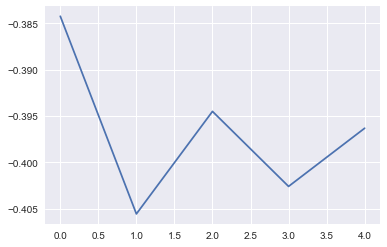

In [29]:
import matplotlib.pyplot as plt
plt.plot(scores, label='True coef')

## Random Forests

In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kegl/

log RMSE: 0.7556 +/-0.0209
CPU times: user 181 ms, sys: 82.4 ms, total: 263 ms
Wall time: 636 ms


## Variable importances

In [23]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
len(X_columns)

153

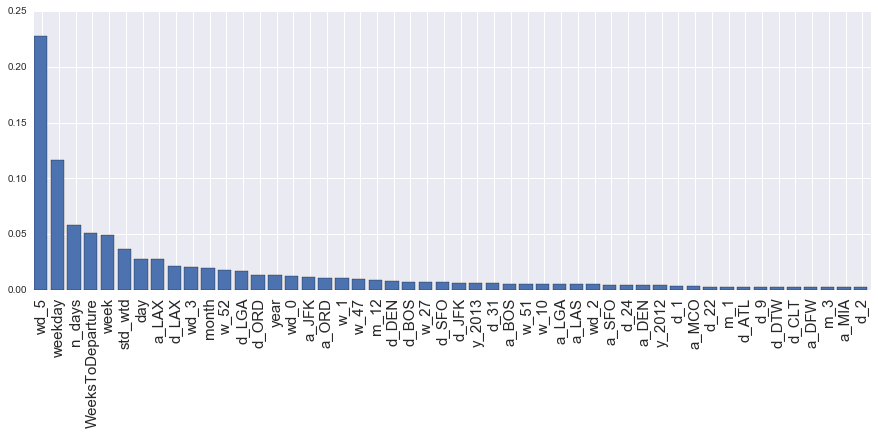

In [25]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Building predictive models

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

The following cell is *not* executed in the notebook, rather it saves its content in the file in the first line, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [36]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded = X_encoded.join(pd.get_dummies(
            X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(
            pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array



Overwriting submissions/starting_kit/feature_extractor.py


### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions.

In [37]:
%%file submissions/starting_kit/regressor.py
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestRegressor(
            n_estimators=10, max_depth=10, max_features=10)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)



Overwriting submissions/starting_kit/regressor.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [30]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Training ./submissions/starting_kit ...
CV fold 0
	train rmse = 0.758
	valid rmse = 0.861
	test rmse = 0.878
CV fold 1
	train rmse = 0.757
	valid rmse = 0.862
	test rmse = 0.876
CV fold 2
	train rmse = 0.738
	valid rmse = 0.854
	test rmse = 0.884
CV fold 3
	train rmse = 0.727
	valid rmse = 0.883
	test rmse = 0.881
CV fold 4
	train rmse = 0.738
	valid rmse = 0.855
	test rmse = 0.876
CV fold 5
	train rmse = 0.755
	valid rmse = 0.856
	test rmse = 0.882
CV fold 6
	train rmse = 0.747
	valid rmse = 0.853
	test rmse = 0.892
CV fold 7
	train rmse = 0.763
	valid rmse = 0.841
	test rmse = 0.879
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
----------------------------
Testing if the notebook can be converted to html
[NbConvertApp] Converting notebook ./air_passengers_starting_kit.ipynb to html
[NbConvertApp] Writing 400437 bytes to ./air_passen

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [31]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [32]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://www.ramp.studio/events/air_passengers_dssp6) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/air_passengers_dssp6/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).